In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/hades/projects/msci-wiki/plots':
  os.chdir(r'/hades/projects/msci-wiki/plots')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


{"/usr/lib/python3.11/importlib/_bootstrap.py": 1693664193.0, "/usr/lib/python3.11/importlib/_bootstrap_external.py": 1693664193.0, "/usr/lib/python3.11/zipimport.py": 1693664193.0, "/usr/lib/python3.11/codecs.py": 1693664193.0, "/usr/lib/python3.11/encodings/aliases.py": 1693664193.0, "/usr/lib/python3.11/encodings/__init__.py": 1693664193.0, "/usr/lib/python3.11/encodings/utf_8.py": 1693664193.0, "/usr/lib/python3.11/abc.py": 1693664193.0, "/usr/lib/python3.11/io.py": 1693664193.0, "/usr/lib/python3.11/stat.py": 1693664193.0, "/usr/lib/python3.11/_collections_abc.py": 1693664193.0, "/usr/lib/python3.11/genericpath.py": 1693664193.0, "/usr/lib/python3.11/posixpath.py": 1693664193.0, "/usr/lib/python3.11/os.py": 1693664193.0, "/usr/lib/python3.11/_sitebuiltins.py": 1693664193.0, "/usr/lib/python3.11/types.py": 1693664193.0, "/usr/lib/python3.11/warnings.py": 1693664193.0, "/usr/lib/python3.11/importlib/__init__.py": 1693664193.0, "/usr/lib/python3.11/importlib/_abc.py": 1693664193.0, "

/tmp/ipykernel_86149/2352873013.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


/tmp/ipykernel_86149/4210353382.py:37: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  axins.set_axes_locator(InsetPosition(axis, [0.492, 0.48, 0.52, 0.52]))


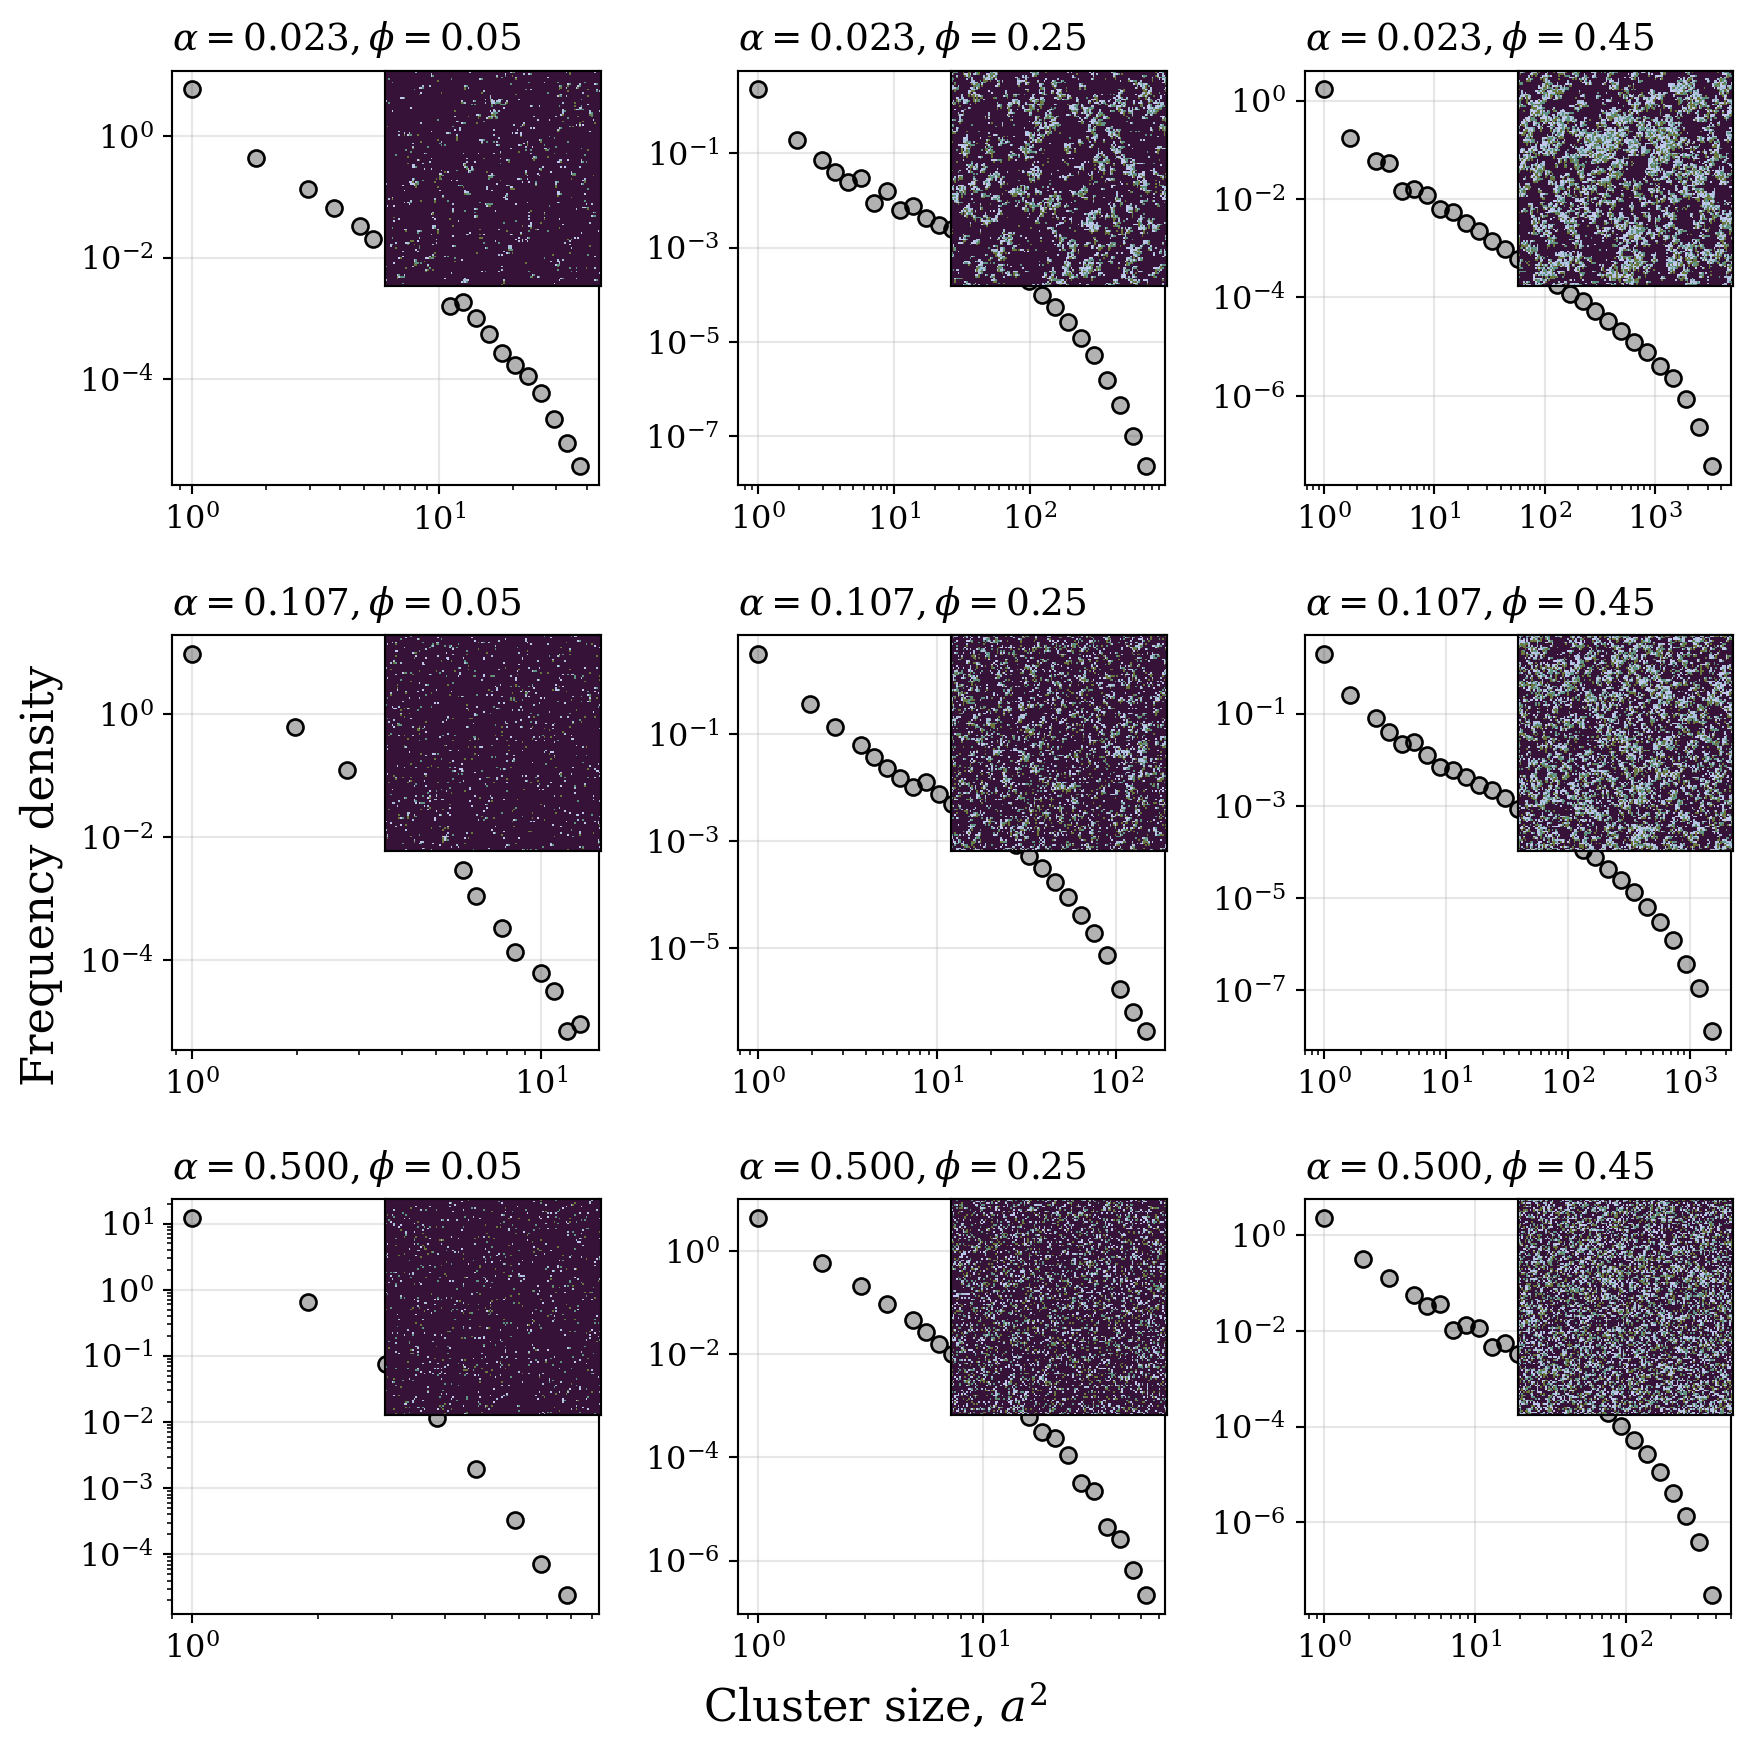

In [2]:
import os
os.chdir("/hades/projects/persistent-exclusion-process/src")

import glob

import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, inset_axes
import numpy as np
from cmcrameri import cm
from scipy import ndimage

from plot_utils import get_plot_configs
from stringato import extract_floats
from utils import get_ds_iters, get_cluster_labels

plot_configs = get_plot_configs()
plot_configs["xtick.labelsize"] = 12
plot_configs["ytick.labelsize"] = 12
plt.rcParams.update(plot_configs)
fig = plt.figure(figsize=(9, 9), constrained_layout=True)
gspec = fig.add_gridspec(3, 3, wspace=0.08, hspace=0.08)
cmap = plt.get_cmap(name="cmc.glasgowS", lut=5)
files = sorted(glob.glob("../bp_data/dataset*"))
stuff = []
for file in files:
    tumble = float(extract_floats(file)[0])
    density = float(extract_floats(file)[1])
    stuff.append((tumble, density))
ctr = 0
text_kwrgs = {"ha": "left", "fontsize": "medium", "fontfamily": "serif"}
kernel = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
for idx in range(3):
    for jdx in range(3):
        axis = fig.add_subplot(gspec[idx, jdx])
        axins = inset_axes(axis, width="100%", height="100%", borderpad=1)
        axins.set_axes_locator(InsetPosition(axis, [0.492, 0.48, 0.52, 0.52]))
        text_kwrgs["s"] = r"$\alpha = {}, \phi = {}$".format(
            files[ctr][26:31], files[ctr][32:36]
        )
        hf = h5py.File(files[ctr], "r")
        key_list = list(hf.keys())
        iters = get_ds_iters(key_list)
        all_cs = np.array([])
        img = hf[f"conf_{iters[-1]}"]
        axins.matshow(img, cmap=cmap)
        axins.set_yticks([])
        axins.set_xticks([])
        for iter in range(len(iters)):
            im = hf[f"conf_{iters[iter]}"]
            labelled, _ = ndimage.label(im, structure=kernel)
            cluster_sizes = np.bincount(labelled.flatten())[1:]
            all_cs = np.hstack((all_cs,cluster_sizes))
        min_c = np.min(all_cs)
        max_c = np.max(all_cs)
        bin_edges = np.logspace(np.log2(min_c), np.log2(max_c), 32, base=2)
        counts, _ = np.histogram(
            all_cs, bins=bin_edges, density=True
        )
        axis.scatter(
            bin_edges[:-1],
            counts,
            edgecolor=(0, 0, 0, 1),
            facecolor=(0, 0, 0, 0.3),
        )
        axis.grid(alpha=.3)
        axis.set_axisbelow(True)
        axis.set_yscale("log"), axis.set_xscale("log")
        axis.text(
            y=1.05,
            x=0,
            transform=axis.transAxes,
            **text_kwrgs,
        )
        # axis.set_ylim((7e-6, 4e1))
        # axis.set_xlim((0, 1.5e3))
        # axis.set_yticks([10**idx for idx in range(-5, 2)])
        # axis.set_xticks([10**idx for idx in range(0, 4)])
        fig.supxlabel(r"Cluster size, $a^{2}$")
        fig.supylabel("Frequency density")
        # if jdx != 0:
        #     axis.set_yticklabels([])
        # if idx != 2:
        #     axis.set_xticklabels([])
        ctr += 1
name = "csize_avg"
fig.savefig(f"../plots/{name}.pdf", bbox_inches="tight")
fig.savefig(f"../plots/{name}.png", bbox_inches="tight")